# Neural Network Classification

- Binary Classification
> Target can be one of two options, e.g. yes or no
- Multi class Classification
> Target can be one of more than two options
- Multi label Classification
> Target can be assigned more than one option

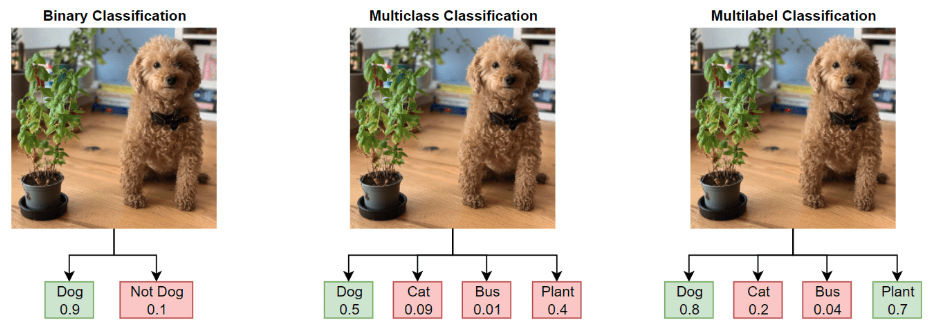

## Loss function

- regression tasks
  - [nn.MSELoss(Mean Square Error)](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)
  - [nn.L1Loss(Mean Absolute Error)](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)

- binary classification tasks
  - [nn.BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)
  - [nn.BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html):   
  combines `nn.Sigmoid` and `nn.BCELoss`

- multi classification tasks
  - [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html):   
  combines `nn.LogSoftmax` and `nn.NLLLoss`

# Setup

## 구글 드라이브 연결

In [1]:
# 구글 드라이브 연결(데이터 로드를 위해서)
from google.colab import drive

drive.mount('/content/data')
DATA_PATH = "/content/data/MyDrive/ai_lecture/2. Deep Learning/data/"

Mounted at /content/data


## install

In [2]:
!pip install -q torchmetrics -U mlxtend torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 12.7 MB/s eta 0:00:00


In [3]:
import torchinfo
import torchmetrics, mlxtend

## Make device agnostic code

In [4]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## accuracy_fn

In [5]:
def accuracy_fn(y_true, y_pred):
    # eq() -> equal를 뜻함 -> eq(y_true, y_pred) -> [true, false, flase, true ..]
    # eq(y_true, y_pred).sum() -> 정답 수
    # eq(y_true, y_pred).sum().item() -> python 형변환 함수
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    # 정확도 = ( 정답 수 / 전체 수 ) * 100
    acc = (correct / len(y_pred)) * 100

    return acc

# Multi-class classification with FashionMNIST
> Let's put everything we've done so far for binary classification together with a multi class classification problem.

## 1.Getting a dataset

### [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist)
- Except it contains grayscale images of 10 different kinds of clothing.

- [torchvision.datasets.FashionMNIST()](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html)  
To download it, we provide the fillowing parameters:
  - `root: str` which folder do you want to dwonload the data to?
  - `train: Bool` do you want the training or test split?
  - `download: Bool` should the data be downloaded?
  - `transform: torchvision.transforms` what transformations would you like to do on the data?

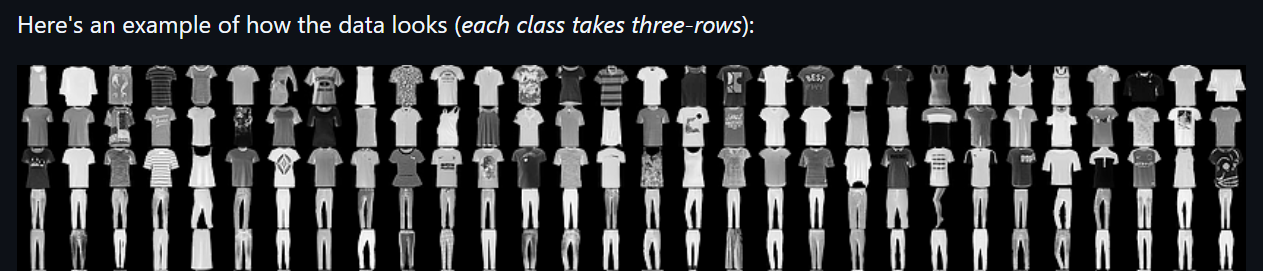

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor

# Setup training data
train_data = datasets.FashionMNIST(
    root="download", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="download",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:01<00:00, 14433302.94it/s]


Extracting download/FashionMNIST/raw/train-images-idx3-ubyte.gz to download/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 222433.03it/s]


Extracting download/FashionMNIST/raw/train-labels-idx1-ubyte.gz to download/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4195521.26it/s]


Extracting download/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to download/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16234794.73it/s]


Extracting download/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to download/FashionMNIST/raw



In [ ]:
type(train_data)

torchvision.datasets.mnist.FashionMNIST

In [ ]:
# See first training sample
# train_data[0] -> __getitem__(index) -> (리턴)features, target
image, label = train_data[0]

In [ ]:
# [color_channels=1, height=28, width=28]
image.shape

torch.Size([1, 28, 28])

### Check out data

In [ ]:
# How many samples are there?
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [ ]:
# See classes
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Image shape: torch.Size([1, 28, 28])


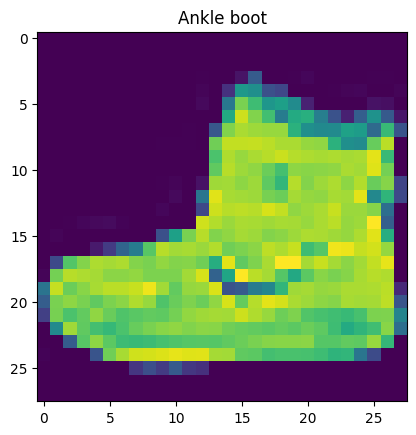

In [ ]:
import matplotlib.pyplot as plt

image, label = train_data[0]
print(f"Image shape: {image.shape}")
# (colour channels, height, width) -> (height, width)
plt.imshow(image.squeeze())
plt.title(class_names[label]);

In [ ]:
# [28, 28] -> (height, width)
# [1, 28, 28] -> (color, height, width)
image.squeeze().shape, image.shape

(torch.Size([28, 28]), torch.Size([1, 28, 28]))

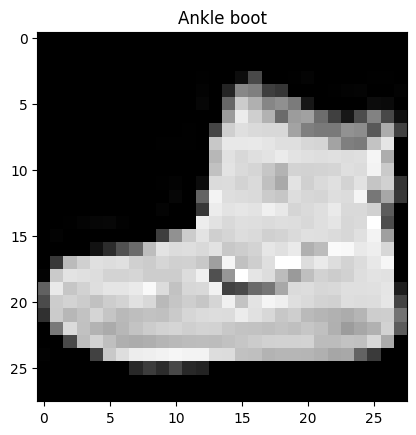

In [ ]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label]);

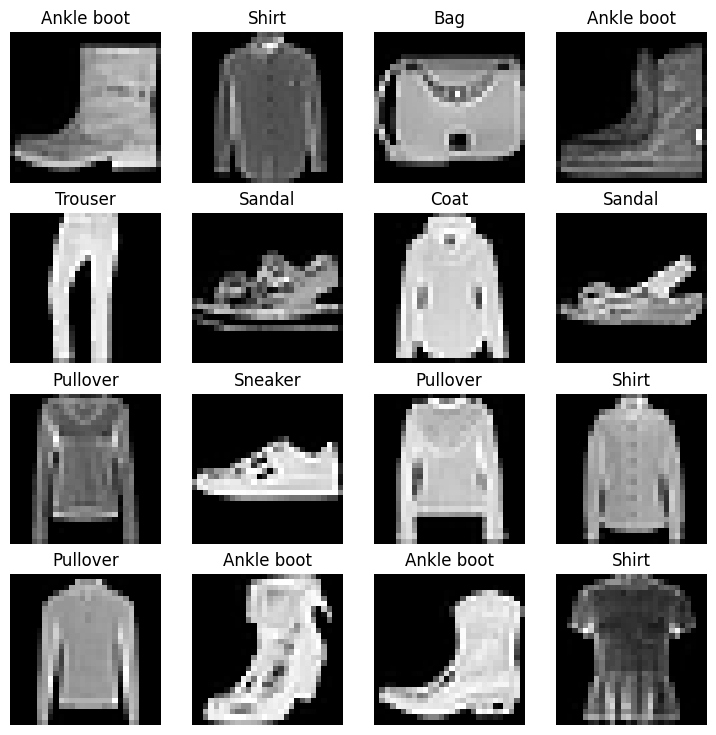

In [ ]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

## 2.DataLoader

In [ ]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7dd75c5bbf70>, <torch.utils.data.dataloader.DataLoader object at 0x7dd75c726380>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


### Check out data

In [ ]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))

# shape: [batch_size=32, color_channels=1, height=28, width=28]
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


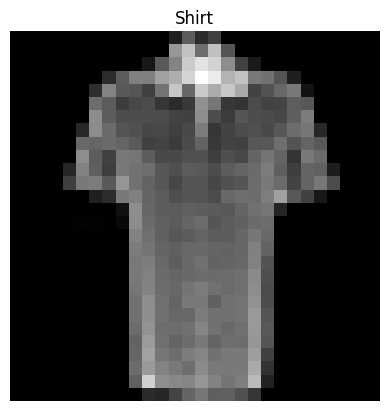

In [ ]:
# Show a sample
torch.manual_seed(42)

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]

plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off");

print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3.Model

In [ ]:
from torch import nn

class MultiClassModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            # [batch, color_channels, height, width] -> [batch, color_channels * height * width]
            nn.Flatten(),

            # [batch, color_channels * height * width] -> [batch, hidden_units]
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),

            # [batch, hidden_units] -> [batch, hidden_units]
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),

            # [batch, hidden_units] -> [batch, output_shape]
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        # [batch, color_channels, height, width] -> [batch, output_shape]
        return self.layer_stack(x)

In [ ]:
multi_class_model = MultiClassModel(
    input_shape=784, # one for every pixel (1x28x28)
    hidden_units=10, # how many units in the hiden layer
    output_shape=len(class_names) # one for every class
).to(device) # keep model on CPU to begin with

multi_class_model

MultiClassModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
# (32, 1, 28, 28) -> [batch_size, color_channels, height, width]
torchinfo.summary(multi_class_model,(32, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MultiClassModel                          [32, 10]                  --
├─Sequential: 1-1                        [32, 10]                  --
│    └─Flatten: 2-1                      [32, 784]                 --
│    └─Linear: 2-2                       [32, 10]                  7,850
│    └─ReLU: 2-3                         [32, 10]                  --
│    └─Linear: 2-4                       [32, 10]                  110
│    └─ReLU: 2-5                         [32, 10]                  --
│    └─Linear: 2-6                       [32, 10]                  110
Total params: 8,070
Trainable params: 8,070
Non-trainable params: 0
Total mult-adds (M): 0.26
Input size (MB): 0.10
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.14

## 4.Training

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=multi_class_model.parameters(), lr=0.1)

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    #################################################################
    ### Training Loop(dataloader) -> 모델 학습
    # 1. Forward -> 학습
    # 2. loss -> 오차
    # 3. Backward -> 수정
    #################################################################
    train_loss = 0
    # Add a loop to loop through training batches
    # enumerate() -> index, data
    # batch -> batch_no / X -> (batch, color, height, width) / y -> (batch, )
    for batch, (X, y) in enumerate(train_dataloader):
        multi_class_model.train()
        # 1. Forward pass
        y_pred = multi_class_model(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)

    #################################################################
    ### Testing Loop -> 모델 평가
    # 1. inference_mode()
    # 2. Forward
    # 3. accuracy_fn()
    #################################################################
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss, test_acc = 0, 0
    multi_class_model.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            # test_pred -> 예측 데이터
            # -> (batch_size, prediction(target_size))
            test_pred = multi_class_model(X)

            # 2. Calculate loss (accumatively)
            # 예측 데이터와 실제 데이터의 오차를 계산
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            # nn.Softmax(dim=1)(test_pred) -> 예측 데이터를 확률 데이터로 변경
            # pred_probab -> (batch_size, probab(target_size))
            pred_probab = nn.Softmax(dim=1)(test_pred)
            # pred_probab.argmax(dim=1) -> 확률이 가장 높은 index(0 ~ 9)를 리턴
            test_acc += accuracy_fn(y_true=y, y_pred=pred_probab.argmax(dim=1))

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.69130 | Test loss: 0.52687, Test acc: 81.71%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.49443 | Test loss: 0.47243, Test acc: 82.95%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45625 | Test loss: 0.45899, Test acc: 83.66%



## 5.Predictions

In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        # sample -> (color, height, width)
        for sample in data:
            # Prepare sample
            # sample -> (batch=1, color, height, width)
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            # pred_logit -> (batch=1, prediction=10)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            # pred_logit.squeeze() -> (prediction=10,)
            # torch.softmax(pred_logit.squeeze(), dim=0)
            # pred_prob -> (probab=10,)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    # torch.stack -> (new=9, pred_probs=10)
    return torch.stack(pred_probs)

In [ ]:
import random

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")


Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 3 (Dress)


In [ ]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=multi_class_model,
                            data=test_samples)

# View first two prediction probabilities list
# pred_probs -> (pred_size=예측 이미지 수, target_size=이미지 종류 수)
print(pred_probs.shape)
pred_probs[:2] # target에 대한 확률값!!

torch.Size([9, 10])


tensor([[1.3985e-04, 2.4384e-02, 1.7297e-04, 9.7309e-01, 1.5612e-03, 4.1474e-06,
         6.5803e-05, 3.8881e-04, 1.3360e-04, 5.9351e-05],
        [9.7054e-01, 4.9341e-07, 6.7397e-06, 9.4356e-04, 1.0140e-06, 3.0246e-09,
         2.8500e-02, 5.3555e-11, 7.7325e-06, 3.0642e-09]])

In [ ]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
print(f'before: {pred_probs.shape}')
# pred_probs -> (batch=9, prob=10)
# pred_probs.argmax(dim=1) -> 확률값이 가장 큰 index 리턴하는 함수
# max/min 과 같이 통계함수를 사용하면, 해당 차원이 사라짐!
# -> (batch(=가장 큰 index),)
pred_classes = pred_probs.argmax(dim=1)
print(f'after: {pred_classes.shape}')
pred_classes

before: torch.Size([9, 10])
after: torch.Size([9])


tensor([3, 0, 1, 7, 5, 6, 1, 6, 6])

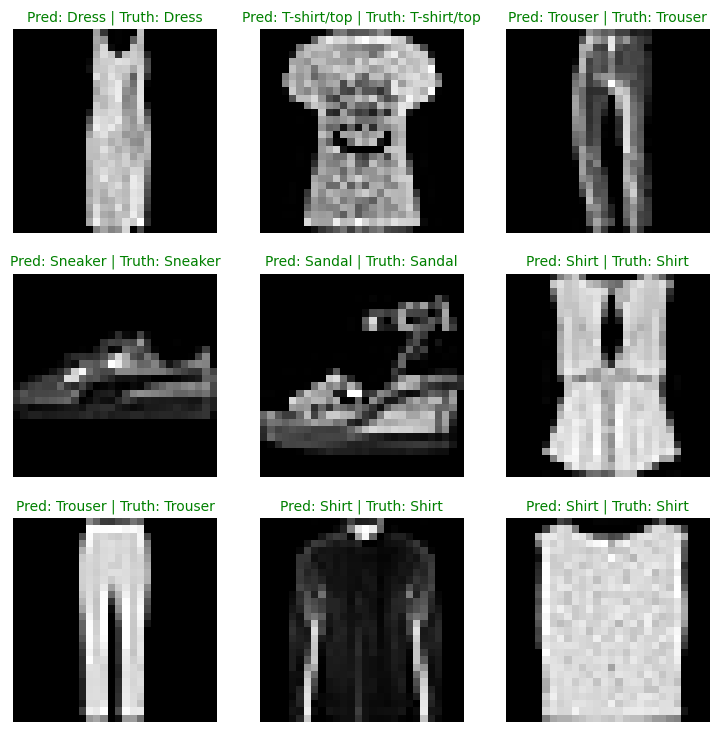

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")

    # Find the prediction label (in text form, e.g. "Sandal")
    pred_label = class_names[pred_classes[i]]

    # Get the truth label (in text form, e.g. "T-shirt")
    truth_label = class_names[test_labels[i]]

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r") # red text if wrong
    plt.axis(False);


### Confusion Matrix

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
multi_class_model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = multi_class_model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1


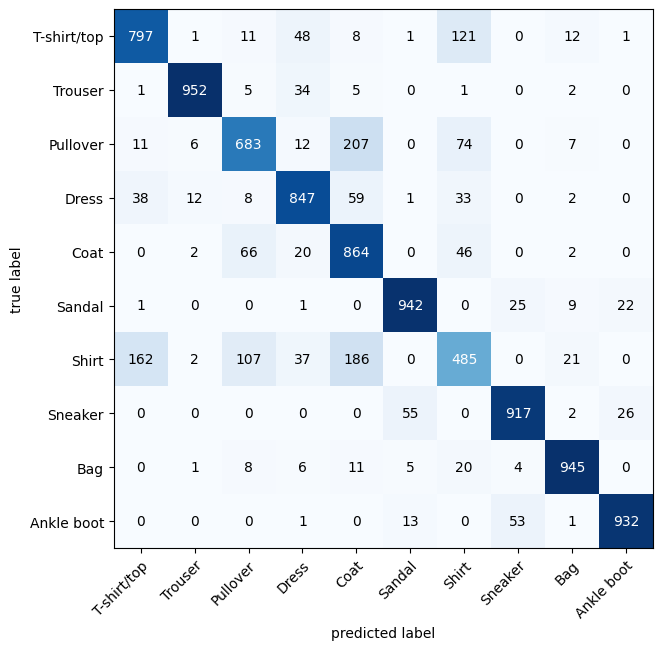

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                        target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

# Multi-class classification with PizzaSteakSushi

## Getting a dataset

In [22]:
import os
import pathlib
from PIL import Image
from pathlib import Path

### Make a Dataset

In [23]:
from torch.utils.data import Dataset

In [24]:
class ImageFolderCustom(Dataset):
    def __init__(self, targ_dir: str, transform=None) -> None:
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        self.classes, self.class_to_idx = self.__find_classes(targ_dir)
        self.transform = transform

    def __find_classes(self, directory: str):
        # 1. Get the class names by scanning the target directory
        classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

        # 2. Raise an error if class names not found
        if not classes:
            raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

        # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

    def __load_image(self, index: int):
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)


    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)


    def __getitem__(self, index: int):
        "Returns one sample of data, data and label (X, y)."
        img = self.__load_image(index)
        class_name  = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

### Make a Transforms

In [25]:
from torchvision import transforms

In [54]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)), # 이미지 크기 변경
    # 이미지의 변형
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.AugMix(),
    transforms.RandAugment(),
    transforms.Grayscale(),
    transforms.ToTensor() # 이미지를 tensor 변경
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((128, 128)), # 이미지 크기 변경
    transforms.Grayscale(),
    transforms.ToTensor() # 이미지를 tensor 변경
])

In [55]:
# python 스트링을 os의 path로 형변환
data_path = Path(DATA_PATH)
image_path = data_path / "pizza_steak_sushi" # data/pizza_steak_sushi

train_dir = image_path / "train"
test_dir = image_path / "test"

In [56]:
train_dataset = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

In [57]:
test_dataset = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [58]:
len(train_dataset), len(test_dataset)

(221, 75)

### Check out data

- 문자를 숫자로 변경

In [59]:
class_to_idx = train_dataset.class_to_idx
class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [60]:
idx = class_to_idx['sushi']
idx

2

- 숫자를 문자로 변경

In [61]:
class_names = train_dataset.classes
class_names

['pizza', 'steak', 'sushi']

In [62]:
class_names[idx]

'sushi'

In [63]:
img, label = train_dataset[0]
img.shape

torch.Size([1, 128, 128])

Original shape: torch.Size([1, 128, 128]) -> [color_channels, height, width]
Image permute shape: torch.Size([128, 128, 1]) -> [height, width, color_channels]


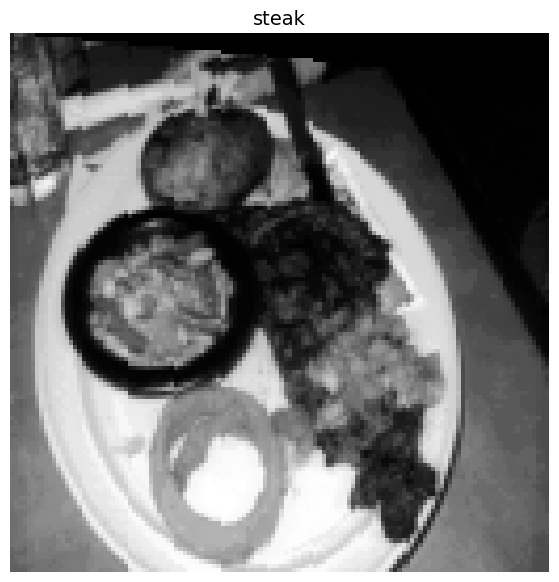

In [64]:
# 시각화 모듈
import matplotlib.pyplot as plt
%matplotlib inline

# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0) # 높이, 너비, 컬러

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0), cmap='gray')
plt.axis("off")
plt.title(class_names[label], fontsize=14);

## DataLoader

In [65]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 30

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_dataset, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x787da887a9e0>, <torch.utils.data.dataloader.DataLoader object at 0x787da887a830>)
Length of train dataloader: 8 batches of 30
Length of test dataloader: 3 batches of 30


### Check out data

In [66]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([30, 1, 128, 128]), torch.Size([30]))

Image size: torch.Size([1, 128, 128])
Label: 2, label size: torch.Size([])


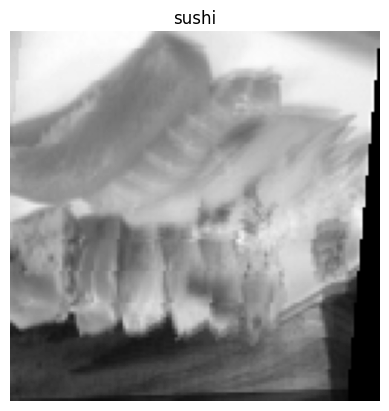

In [67]:
# Show a sample
torch.manual_seed(42)

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt_img = img.permute(1, 2, 0) # 높이, 너비, 컬러

plt.imshow(plt_img, cmap='gray')
plt.title(class_names[label])
plt.axis("Off");

print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 1.Experiment

### Model

In [68]:
from torch import nn

class MultiClassModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),

            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),

            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),

            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [69]:
multi_class_modelV0 = MultiClassModelV0(
    input_shape=1*128*128, # one for every pixel (1x128x128)
    hidden_units=10, # how many units in the hiden layer
    output_shape=len(train_dataset.classes) # one for every class
).to(device) # keep model on CPU to begin with

multi_class_modelV0

MultiClassModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [70]:
torchinfo.summary(multi_class_modelV0,(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
MultiClassModelV0                        [32, 3]                   --
├─Sequential: 1-1                        [32, 3]                   --
│    └─Flatten: 2-1                      [32, 16384]               --
│    └─Linear: 2-2                       [32, 10]                  163,850
│    └─ReLU: 2-3                         [32, 10]                  --
│    └─Linear: 2-4                       [32, 10]                  110
│    └─ReLU: 2-5                         [32, 10]                  --
│    └─Linear: 2-6                       [32, 3]                   33
Total params: 163,993
Trainable params: 163,993
Non-trainable params: 0
Total mult-adds (M): 5.25
Input size (MB): 2.10
Forward/backward pass size (MB): 0.01
Params size (MB): 0.66
Estimated Total Size (MB): 2.76

### Training

In [71]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=multi_class_modelV0.parameters(), lr=0.1)

In [72]:
multi_class_modelV0 = MultiClassModelV0(
    input_shape=1*128*128, # one for every pixel (3x128x128)
    hidden_units=10, # how many units in the hiden layer
    output_shape=len(train_dataset.classes) # one for every class
).to(device)

In [73]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []
epochs = 10

for epoch in tqdm(range(epochs)):
    #################################################################
    ### Training Loop(dataloader) -> 모델 학습
    #################################################################
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        multi_class_modelV0.train()
        y_pred = multi_class_modelV0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    #################################################################
    ### Testing Loop -> 모델 평가
    #################################################################
    test_loss, test_acc = 0, 0
    multi_class_modelV0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = multi_class_modelV0(X)
            test_loss += loss_fn(test_pred, y)
            pred_probab = nn.Softmax(dim=1)(test_pred)
            test_acc += accuracy_fn(y_true=y, y_pred=pred_probab.argmax(dim=1))

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    epoch_count.append(epoch)
    # loss.detach() -> loss가 들어있는 device를 cpu로 변경
    # loss.detach().numpy() -> torch를 numpy 변환
    train_loss_values.append(train_loss.detach().numpy())
    test_loss_values.append(test_loss.detach().numpy())
    print(f"Epoch: {epoch} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.12143 | Test loss: 1.13642, Test acc: 27.78%

Epoch: 1 | Train loss: 1.11773 | Test loss: 1.13642, Test acc: 27.78%

Epoch: 2 | Train loss: 1.10851 | Test loss: 1.13642, Test acc: 27.78%

Epoch: 3 | Train loss: 1.11965 | Test loss: 1.13642, Test acc: 27.78%

Epoch: 4 | Train loss: 1.11222 | Test loss: 1.13642, Test acc: 27.78%

Epoch: 5 | Train loss: 1.12483 | Test loss: 1.13642, Test acc: 27.78%

Epoch: 6 | Train loss: 1.11664 | Test loss: 1.13642, Test acc: 27.78%

Epoch: 7 | Train loss: 1.12581 | Test loss: 1.13642, Test acc: 27.78%

Epoch: 8 | Train loss: 1.10901 | Test loss: 1.13642, Test acc: 27.78%

Epoch: 9 | Train loss: 1.11723 | Test loss: 1.13642, Test acc: 27.78%



### Plot the loss curves

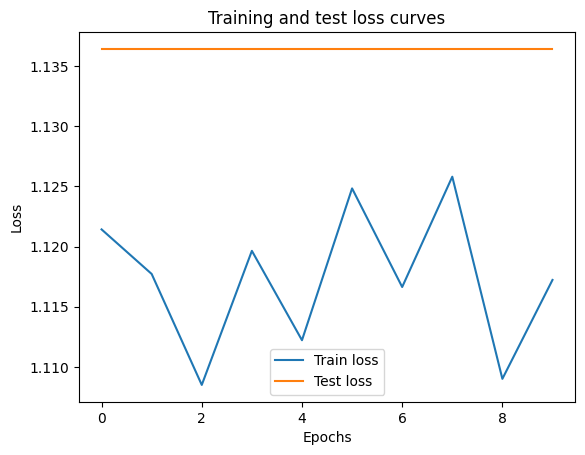

In [74]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

### Predictions

In [75]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [76]:
import random

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_dataset), k=4):
    test_samples.append(sample)
    test_labels.append(label)

In [77]:
pred_probs= make_predictions(model=multi_class_modelV0,
                            data=test_samples)

print(pred_probs.shape)

torch.Size([4, 3])


In [78]:
pred_classes = pred_probs.argmax(dim=1)

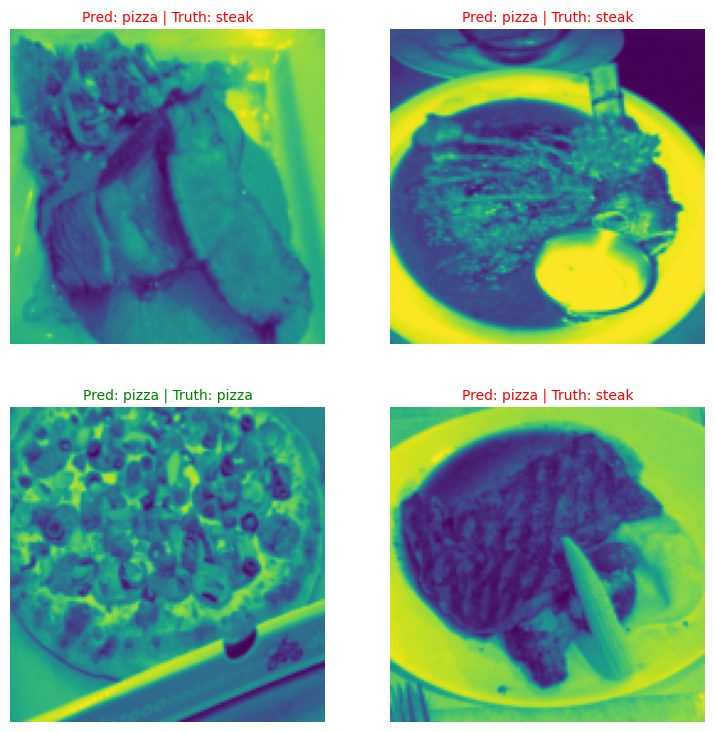

In [79]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 2
ncols = 2

for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.permute(1, 2, 0))

    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]

    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r") # red text if wrong
    plt.axis(False);

### Confusion Matrix

In [80]:
y_preds = []
multi_class_modelV0.eval()

with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)

    y_logit = multi_class_modelV0(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/3 [00:00<?, ?it/s]

In [81]:
len(y_pred_tensor), type(y_pred_tensor)

(75, torch.Tensor)

In [82]:
test_targets = []
for features, target in test_dataset:
    test_targets.append(target)

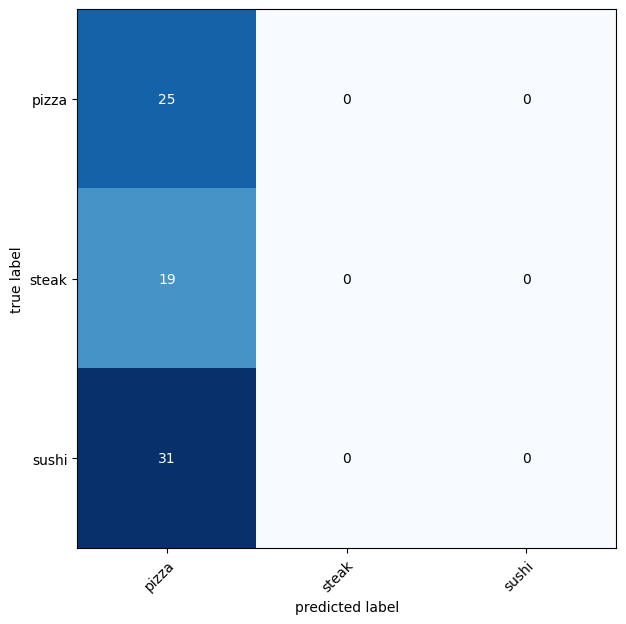

In [83]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                        target=torch.tensor(test_targets))

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

## 2.Experiment
> We've trained an evaluated a model but it's not working, let's try a few things to improve it.


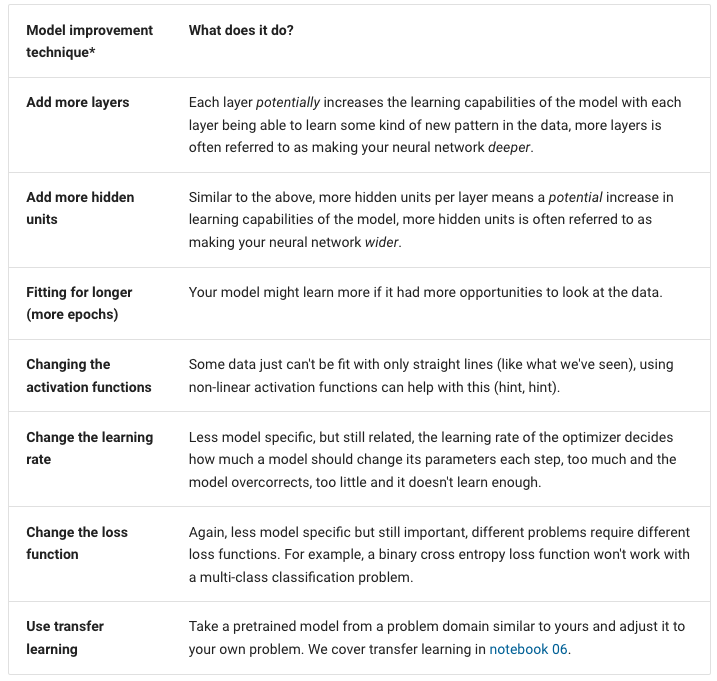

### Model

In [84]:
from torch import nn

class MultiClassModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),

            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=int(hidden_units/2)),
            nn.ReLU(),
            nn.Linear(in_features=int(hidden_units/2), out_features=int(hidden_units/2)),
            nn.ReLU(),

            nn.Linear(in_features=int(hidden_units/2), out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

### Training

In [85]:
multi_class_modelV1 = MultiClassModelV1(
    input_shape=1*128*128, # one for every pixel (1x128x128)
    hidden_units=512, # how many units in the hiden layer
    output_shape=len(train_dataset.classes) # one for every class
).to(device) # keep model on CPU to begin with

In [86]:
torchinfo.summary(multi_class_modelV1,(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
MultiClassModelV1                        [32, 3]                   --
├─Sequential: 1-1                        [32, 3]                   --
│    └─Flatten: 2-1                      [32, 16384]               --
│    └─Linear: 2-2                       [32, 512]                 8,389,120
│    └─ReLU: 2-3                         [32, 512]                 --
│    └─Linear: 2-4                       [32, 512]                 262,656
│    └─ReLU: 2-5                         [32, 512]                 --
│    └─Linear: 2-6                       [32, 256]                 131,328
│    └─ReLU: 2-7                         [32, 256]                 --
│    └─Linear: 2-8                       [32, 256]                 65,792
│    └─ReLU: 2-9                         [32, 256]                 --
│    └─Linear: 2-10                      [32, 3]                   771
Total params: 8,849,667
Trainable params: 8,849,667
Non-trainab

In [87]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.Adam(params=multi_class_modelV1.parameters(), lr=0.1)

In [88]:
from tqdm.auto import tqdm

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []
epochs = 50

for epoch in tqdm(range(epochs)):
    #################################################################
    ### Training Loop(dataloader) -> 모델 학습
    #################################################################
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        multi_class_modelV1.train()
        y_pred = multi_class_modelV1(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    #################################################################
    ### Testing Loop -> 모델 평가
    #################################################################
    test_loss, test_acc = 0, 0
    multi_class_modelV1.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = multi_class_modelV1(X)
            test_loss += loss_fn(test_pred, y)
            pred_probab = nn.Softmax(dim=1)(test_pred)
            test_acc += accuracy_fn(y_true=y, y_pred=pred_probab.argmax(dim=1))

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    if epoch % 5 == 0:
      ## Print out what's happening
      epoch_count.append(epoch)
      train_loss_values.append(train_loss.detach().numpy())
      test_loss_values.append(test_loss.detach().numpy())
      print(f"Epoch: {epoch} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 816603.81250 | Test loss: 112692.39844, Test acc: 34.44%

Epoch: 5 | Train loss: 3359.74829 | Test loss: 348.29410, Test acc: 40.00%

Epoch: 10 | Train loss: 96.97744 | Test loss: 26.47944, Test acc: 37.78%

Epoch: 15 | Train loss: 319.53558 | Test loss: 1.41889, Test acc: 27.78%

Epoch: 20 | Train loss: 1.11631 | Test loss: 1.10504, Test acc: 34.44%

Epoch: 25 | Train loss: 1.11492 | Test loss: 1.10115, Test acc: 37.78%

Epoch: 30 | Train loss: 1.10094 | Test loss: 1.10053, Test acc: 34.44%

Epoch: 35 | Train loss: 1.10755 | Test loss: 1.10181, Test acc: 27.78%

Epoch: 40 | Train loss: 1.11488 | Test loss: 1.09463, Test acc: 37.78%

Epoch: 45 | Train loss: 1.10674 | Test loss: 1.10016, Test acc: 34.44%



### Plot the loss curves

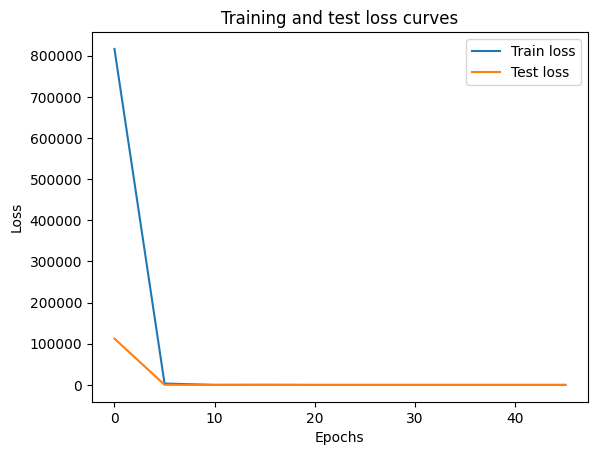

In [89]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

### Predictions

In [90]:
import random

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_dataset), k=4):
    test_samples.append(sample)
    test_labels.append(label)

In [91]:
pred_probs= make_predictions(model=multi_class_modelV1,
                            data=test_samples)

print(pred_probs.shape)

torch.Size([4, 3])


In [92]:
pred_classes = pred_probs.argmax(dim=1)

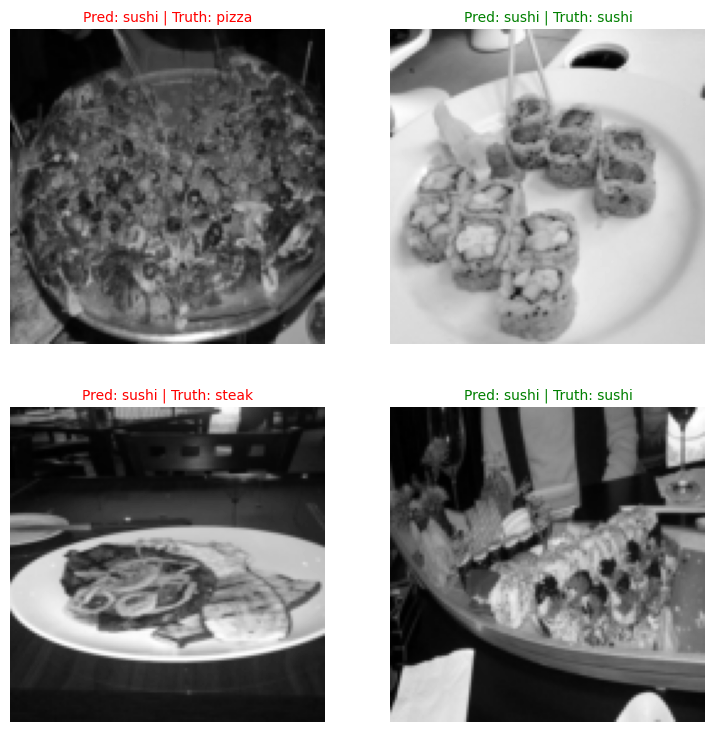

In [97]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 2
ncols = 2

for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.permute(1, 2, 0), cmap='gray')

    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]

    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r") # red text if wrong
    plt.axis(False);

### Confusion Matrix

In [94]:
y_preds = []
multi_class_modelV1.eval()

with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)

    y_logit = multi_class_modelV1(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/3 [00:00<?, ?it/s]

In [95]:
test_targets = []
for features, target in test_dataset:
    test_targets.append(target)

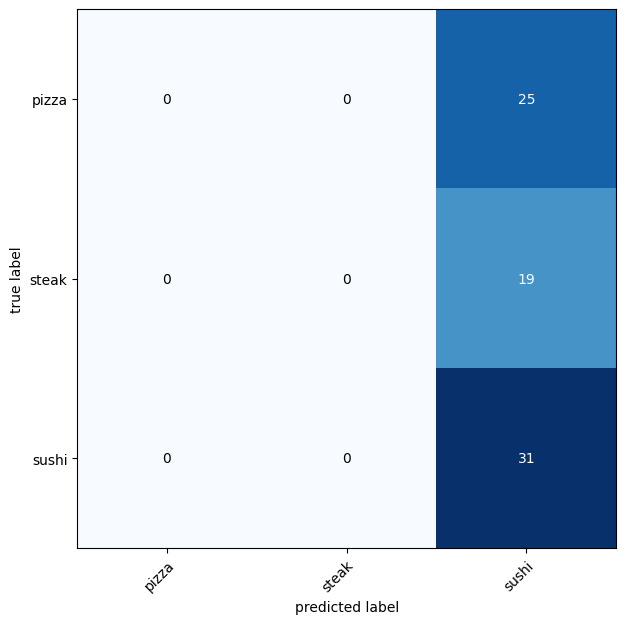

In [96]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                        target=torch.tensor(test_targets))

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);